load a wav file

In [1]:
import wave
import struct
import wavio
import numpy as np
from matplotlib import pyplot as plt

file = 'okgoogle_44200.wav'
voice = wave.open(file, 'rb')
Fs = voice.getframerate()
Fc=25e3
n_channels = voice.getnchannels()
n_samples = voice.getnframes()
sampwidth = voice.getsampwidth()
sample_max_range = (pow(2,8*sampwidth))/2
data = voice.readframes(n_samples)
array = wavio._wav2array(n_channels, sampwidth, data)
array = array / sample_max_range # normalization
array.shape

(134144, 2)

Resampling (optional)

In [2]:
from scipy.signal import resample
if Fs != 88200:
    n_samples = int(n_samples * (88200/Fs))
    array = resample(array, n_samples)
    
Fs = 88200
t = np.arange(n_samples)

plot the input voice signal (ch1)

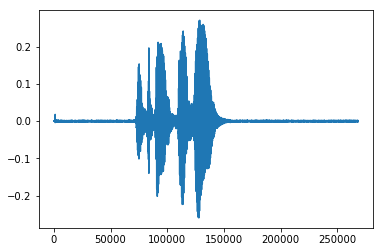

In [3]:
plt.plot(t, array[:,1])
plt.show()

generate a carrier signal

In [4]:
carrier = np.array([np.cos(2*np.pi*Fc*(1/Fs)*t)]*n_channels).transpose();
carrier.shape

(268288, 2)

modulated signal on a carrier

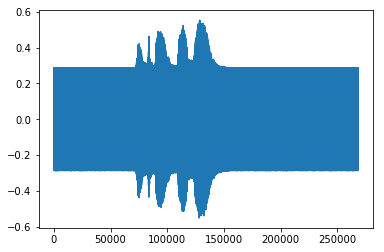

In [5]:
mod = np.multiply(array, carrier) - np.min(array)*1.1*carrier
plt.plot(t, mod[:, 0])
plt.show()

In [10]:
import sounddevice as sd
sd.play(mod[:,0]*1.3, Fs)

mic out

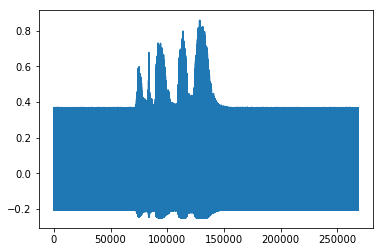

In [6]:
mic_out = 1*mod+1*np.power(mod,2) # non-linearity characteristic
plt.plot(t, mic_out[:, 0])
plt.show()

FFT result

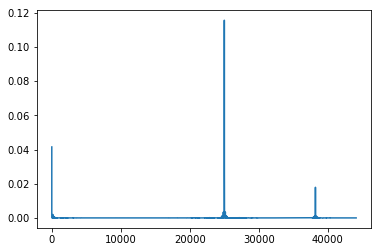

In [7]:
T = n_samples/Fs
frq = t/T # two sides frequency range
frq = frq[range(int(n_samples/2))] # one side frequency range
Y = np.fft.fft(mic_out[:,0])/n_samples # fft computing and normalization
Y = Y[range(int(n_samples/2))]
plt.plot(frq,abs(Y))
plt.show()

apply a low pass filter

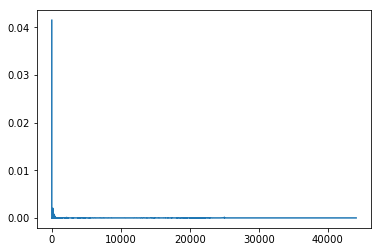

In [8]:
from scipy.signal import butter, lfilter, freqz

def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a


def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y

order = 32
cutoff = 22100
filter_out = np.zeros((n_samples, n_channels))
for i in range(n_channels):
    filter_out[:, i] = butter_lowpass_filter(mic_out[:, i], cutoff, Fs, order)
Y = np.fft.fft(filter_out[:,0])/n_samples # fft computing and normalization
Y = Y[range(int(n_samples/2))]
plt.plot(frq,abs(Y))
plt.show()

play

In [9]:
import sounddevice as sd
sd.play(filter_out[:,0]*1.3, Fs)